In [3]:
import pandas as pd
import scipy.sparse as sp
import numpy as np
import json
import torch
from tqdm import tqdm

In [2]:
df_tags = pd.read_csv('./data/yelp/fold0/tr_tags.csv')

rows, cols = df_tags.item, df_tags.tag
values = np.ones(len(df_tags))

m_item_keyphrase= sp.csr_matrix((values, (rows, cols)), dtype='float64')

with open('./data/yelp/tag_id_dict.json') as f:
    tag_id_dict = json.load(f)
#with open('./data/yelp/id_business_dict.json') as f:
#    id_id_dict = json.load(f)

id_tag_dict = {id: tag for tag, id in tag_id_dict.items()}
#id_title_dict = {id: title for title, id in title_id_dict.items()}

PATH = './saves/yelp/VAE_beta_multilayer.pt'
model = torch.load(PATH, map_location=torch.device('cpu'))
item_embeddings = model.decoder.weight.detach().numpy()

from utils.KAVgenerator import KAVgenerator
k = KAVgenerator(m_item_keyphrase,item_embeddings, 20)
keyphrase_embeddings = k.get_all_mean_kav(20, 20)

100%|██████████| 245/245 [00:05<00:00, 48.13it/s](245, 20, 100)



In [3]:
from utils.Dataset import Dataset
dataset = Dataset(data_dir='./data/yelp/fold0/',load_keyphrases=True)

Read data from ./data/yelp/fold0/


In [4]:
def get_mu_cov(user_id, input_matrix, moddel):
    user_input = input_matrix[user_id]
    i = torch.FloatTensor(user_input.toarray()).to(torch.device('cpu'))
    with torch.no_grad():
        mu, logvar = model.get_mu_logvar(i)
    std = model.logvar2std(logvar)
    mu, std = mu.numpy().T, std.numpy()

    return mu, np.diagflat(std*std)

def update_posterior(x, y, S_0, m_0, prec_y):
    S_0_inv = np.linalg.inv(S_0)
    #S_1 = np.linalg.inv(S_0_inv +prec_y * x @ x.T)    
    #print(np.swapaxes(x,-2,-1).shape)
    S_1 = np.linalg.inv(S_0_inv +prec_y * np.matmul(x,np.swapaxes(x,-2,-1)))
    m_1 = S_1 @ (S_0_inv @ m_0 + prec_y * y * x)
    #print(m_1.shape)
    return S_1, m_1

In [5]:
# for all users:
    # compute rates
    # update
    # compute updated_rates
    # updated_rates - rates
    # separate and add
# take average

def eval_routine(keyphrase_id, keyphrase_embeddings, train_matrix, model, prec_y, is_positive):
    x = keyphrase_embeddings[keyphrase_id][:,np.newaxis]
    mask = np.array((m_item_keyphrase[:,keyphrase_id]>20).todense()).squeeze()
    pos_item_ids = mask.nonzero()[0]
    print(len(pos_item_ids))
    neg_item_ids = (1-mask).nonzero()[0]
    pos = []
    neg = []

    for user_id in tqdm(range(train_matrix.shape[0])):
        mu, cov = get_mu_cov(user_id, train_matrix, model)
        updated_preds = eval_subroutine(mu, cov, model, x, prec_y, is_positive)
        pos.append(np.mean(updated_preds[pos_item_ids]))
        neg.append(np.mean(updated_preds[neg_item_ids]))

    return (np.mean(pos) - np.mean(neg)) /  np.mean(neg)


def eval_subroutine(mu, cov, model, x, prec_y, is_positive):
    #_mu = torch.FloatTensor(mu.T)
    #with torch.no_grad():
    #    preds = model.decoder(_mu)
    # initial_preds = np.asarray(preds).reshape(-1)
    y = np.max(mu.T @ keyphrase_embeddings.T) if is_positive \
                    else np.min(mu.T @ keyphrase_embeddings.T)
    
    cov1, mu1 = update_posterior(x, y, cov, mu, prec_y)
    _mu = torch.FloatTensor(mu1.T)
    with torch.no_grad():
        preds = model.decoder(_mu)
    updated_preds = np.asarray(preds).reshape(-1)
    #diffs = (updated_preds - initial_preds) / np.abs(initial_preds)

    return updated_preds


In [11]:
tag_id_dict

{'tea': 0,
 'parking': 1,
 'cookie': 2,
 'milk': 3,
 'quick': 4,
 'pricey': 5,
 'bar': 6,
 'coffee': 7,
 'green tea': 8,
 'convenient': 9,
 'fancy': 10,
 'chocolate': 11,
 'banana': 12,
 'lemon': 13,
 'milk tea': 14,
 'busy': 15,
 'fresh': 16,
 'friendly': 17,
 'quiet': 18,
 'music': 19,
 'chip': 20,
 'baked': 21,
 'ambiance': 22,
 'sandwich': 23,
 'latte': 24,
 'window': 25,
 'cozy': 26,
 'decent price': 27,
 'flavorful': 28,
 'coconut': 29,
 'fried': 30,
 'fish': 31,
 'fry': 32,
 'shrimp': 33,
 'scallop': 34,
 'calamari': 35,
 'dark': 36,
 'deep fried': 37,
 'efficient': 38,
 'classic': 39,
 'taco': 40,
 'lettuce': 41,
 'corn': 42,
 'tomato': 43,
 'fair': 44,
 'sour': 45,
 'soup': 46,
 'salad': 47,
 'crispy': 48,
 'seafood': 49,
 'meat': 50,
 'lobster': 51,
 'bun': 52,
 'mayo': 53,
 'salt': 54,
 'juicy': 55,
 'fast': 56,
 'wait': 57,
 'stuffed': 58,
 'yummy': 59,
 'cake': 60,
 'squid': 61,
 'ice cream': 62,
 'clean': 63,
 'juice': 64,
 'honey': 65,
 'smooth': 66,
 'stick': 67,
 'crea

In [13]:
keyphrase = 'breakfast'
keyphrase_id = tag_id_dict[keyphrase]
print('ADS')
result = {'Rating Difference Rate': [], 'Precision':[], 'Direction':[]}
for prec in [0, 1, 10, 100, 1000]:
    metric = eval_routine(keyphrase_id, keyphrase_embeddings, dataset.train_matrix, model, prec, True)
    result['Rating Difference Rate'].append(metric)
    result['Precision'].append(prec)
    result['Direction'].append('Pos')
    if prec == 0:
        result['Rating Difference Rate'].append(metric)
        result['Precision'].append(prec)
        result['Direction'].append('Neg')

for prec in [1, 10, 100, 1000]:
    metric = eval_routine(keyphrase_id, keyphrase_embeddings, dataset.train_matrix, model, prec, False)
    result['Rating Difference Rate'].append(metric)
    result['Precision'].append(prec)
    result['Direction'].append('Neg')
 





0%|          | 19/7000 [00:00<00:40, 174.39it/s]ADS
40
100%|██████████| 7000/7000 [00:18<00:00, 385.84it/s]


In [4]:
from pathlib import Path
save_dir = Path("./saves/yelp/"+keyphrase+'.csv') 
pd.DataFrame(result).to_csv(str(save_dir), index=False)

NameError: name 'result' is not defined

In [15]:
a = pd.DataFrame(result)

In [ ]:
keyphrase = 'anime'
a = pd.read_csv('./saves/ml10/'+keyphrase+'.csv')

In [9]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

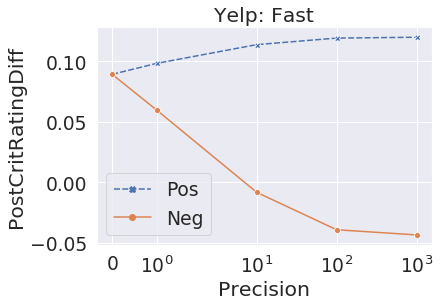

In [10]:
sns.set_style("darkgrid")
sns.set(font_scale=1.7)  # crazy big
k = a.pivot("Precision", "Direction", "Rating Difference Rate")
plot = sns.lineplot(data=k, markers=True, dashes=True, hue_order=['Pos','Neg'])
plot.set_xscale('symlog')
plot.set_title('   : Fast')
plot.set_ylabel('PostCritRatingDiff')
plot.figure.savefig("./saves/yelp/"+keyphrase+'.pdf',bbox_inches='tight')

In [46]:
k

prec,0,10,100
is_pos,,,
neg,0,-10,-100
pos,0,10,100


[Text(0, 0, '10'), Text(0, 0, '0'), Text(0, 0, '10')]

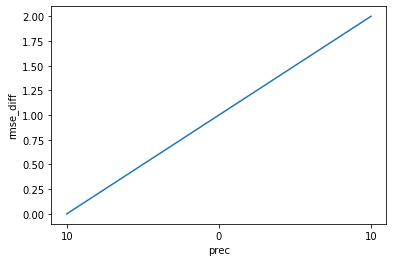

In [41]:
#g = sns.lineplot(data=a, x='prec', y='rmse_diff')
#g.set_xticks([-10,0,10])
#g.set_xticklabels(['10','0','10'])

In [9]:
id_tag_dict

{0: 'tea',
 1: 'parking',
 2: 'cookie',
 3: 'milk',
 4: 'quick',
 5: 'pricey',
 6: 'bar',
 7: 'coffee',
 8: 'green tea',
 9: 'convenient',
 10: 'fancy',
 11: 'chocolate',
 12: 'banana',
 13: 'lemon',
 14: 'milk tea',
 15: 'busy',
 16: 'fresh',
 17: 'friendly',
 18: 'quiet',
 19: 'music',
 20: 'chip',
 21: 'baked',
 22: 'ambiance',
 23: 'sandwich',
 24: 'latte',
 25: 'window',
 26: 'cozy',
 27: 'decent price',
 28: 'flavorful',
 29: 'coconut',
 30: 'fried',
 31: 'fish',
 32: 'fry',
 33: 'shrimp',
 34: 'scallop',
 35: 'calamari',
 36: 'dark',
 37: 'deep fried',
 38: 'efficient',
 39: 'classic',
 40: 'taco',
 41: 'lettuce',
 42: 'corn',
 43: 'tomato',
 44: 'fair',
 45: 'sour',
 46: 'soup',
 47: 'salad',
 48: 'crispy',
 49: 'seafood',
 50: 'meat',
 51: 'lobster',
 52: 'bun',
 53: 'mayo',
 54: 'salt',
 55: 'juicy',
 56: 'fast',
 57: 'wait',
 58: 'stuffed',
 59: 'yummy',
 60: 'cake',
 61: 'squid',
 62: 'ice cream',
 63: 'clean',
 64: 'juice',
 65: 'honey',
 66: 'smooth',
 67: 'stick',
 68: '